In [14]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
%matplotlib inline

In [15]:
renders_dir = 'renders_output/dsnerf_fixed_cosine_loss/'

# Check over 92 and 93 those are images where I know there are points we see on both images
image_1_features_path = renders_dir + 'out_0_features.pt'
image_1_path = renders_dir + 'in_0_image.pt'
depth_1_path = renders_dir + 'in_0_gt_depth.pt'

image_2_features_path = renders_dir + 'out_1_features.pt'
image_2_path = renders_dir + 'in_1_image.pt'
depth_2_path = renders_dir + 'in_1_gt_depth.pt'

# In format of tev's (h, w) (in tev it is written (w,h) you can know by moving the cursor from left to right over an image)
points_to_check = [(30, 900)]#, (35, 129), (54, 160), (162, 47)]
colors = [np.array([0,0,255]), np.array([255,0,0]), np.array([0,255,0]), np.array([255,255,0])]

img_1_tensor = torch.load(image_1_path)
img_2_tensor = torch.load(image_2_path)
features_1 = torch.load(image_1_features_path).numpy()
features_2 = torch.load(image_2_features_path).numpy()
depth_1 = torch.load(depth_1_path).numpy()
depth_2 = torch.load(depth_2_path).numpy()

Find matching points from supervision:

In [16]:
depth_idx_1 = depth_1[~np.isnan(depth_1[:,:,0]),2]
depth_idx_2 = depth_2[~np.isnan(depth_2[:,:,0]),2]

idxs_in_both = depth_idx_1[np.isin(depth_idx_1, depth_idx_2)]
idxs_in_both.shape

(688,)

In [17]:
# Samples points to check in image 1:
points_N = 5
np.random.seed(1)

points_to_check_idx = idxs_in_both[np.random.choice(idxs_in_both.shape[0], points_N, replace=False)]

points_to_check = np.argwhere(np.isin(depth_1[:,:,2], points_to_check_idx))
print('Points to check in image 1:', points_to_check)

# Provide the gt:
matching_points = []
for p in points_to_check:
    p_colmap_idx = depth_1[p[0],p[1],2]
    matching_points.append(np.argwhere(depth_2[:,:,2] == p_colmap_idx)[0])
matching_points = np.array(matching_points)
print('Mathcing points in image 2:', matching_points)

print(depth_1[points_to_check[:,0], points_to_check[:,1], 2])
print(depth_2[matching_points[:,0], matching_points[:,1], 2])

Points to check in image 1: [[ 92  77]
 [154 264]
 [400 492]
 [518 395]
 [579 244]]
Mathcing points in image 2: [[103 118]
 [173 284]
 [410 518]
 [543 402]
 [583 274]]
[ 1802. 13054. 10107.  9697.  8947.]
[ 1802. 13054. 10107.  9697.  8947.]


In [18]:
def cos_sim(a, b, axis=2):
    return (a * b).sum(axis=axis) / (np.linalg.norm(a, axis=axis) * np.linalg.norm(b, axis=axis))

# a_check = np.array([
#   [1,2,1],
#     # [1,2,1],
#     # [2,4,2],
#     # [1,0,0],
#     # [0,0,1],
#     # [1,0,0]
# ])
# b_check = np.array([
#   [1,2,1],
#     [2,4,2],
#     [1,2,1],
#     [0,0,1],
#     [1,0,0],
#     [1,1,0]
# ])

# cos_sim(a_check, b_check, axis=1)

Now search for nearest and render

[92 77]
[92 77]
[101 119] 0.97720987
[102 120] 0.9771696
[101 120] 0.9770696
[103 120] 0.97681826
[100 118] 0.9767242
Cosine Similarity to gt match [103 118]  : 0.9765329
[154 264]


/tmp/ipykernel_3886837/2485693389.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * b).sum(axis=axis) / (np.linalg.norm(a, axis=axis) * np.linalg.norm(b, axis=axis))


[154 264]
[158 313] 0.9581721
[159 315] 0.9579581
[155 311] 0.95774317
[157 312] 0.9576255
[158 312] 0.95732915
Cosine Similarity to gt match [173 284]  : 0.9501093
[400 492]
[400 492]
[400 529] 0.9648298
[400 530] 0.96443
[401 529] 0.9632558
[400 528] 0.9624734
[400 531] 0.9623049
Cosine Similarity to gt match [410 518]  : 0.89762336
[518 395]
[518 395]
[517 430] 0.9883447
[517 431] 0.9874976
[518 430] 0.9859662
[517 429] 0.98595214
[518 431] 0.98580796
Cosine Similarity to gt match [543 402]  : 0.8020745
[579 244]
[579 244]
[576 282] 0.96829164
[574 281] 0.9679022
[574 282] 0.9678791
[575 282] 0.96712255
[575 283] 0.9667572
Cosine Similarity to gt match [583 274]  : 0.95384437


'img1'

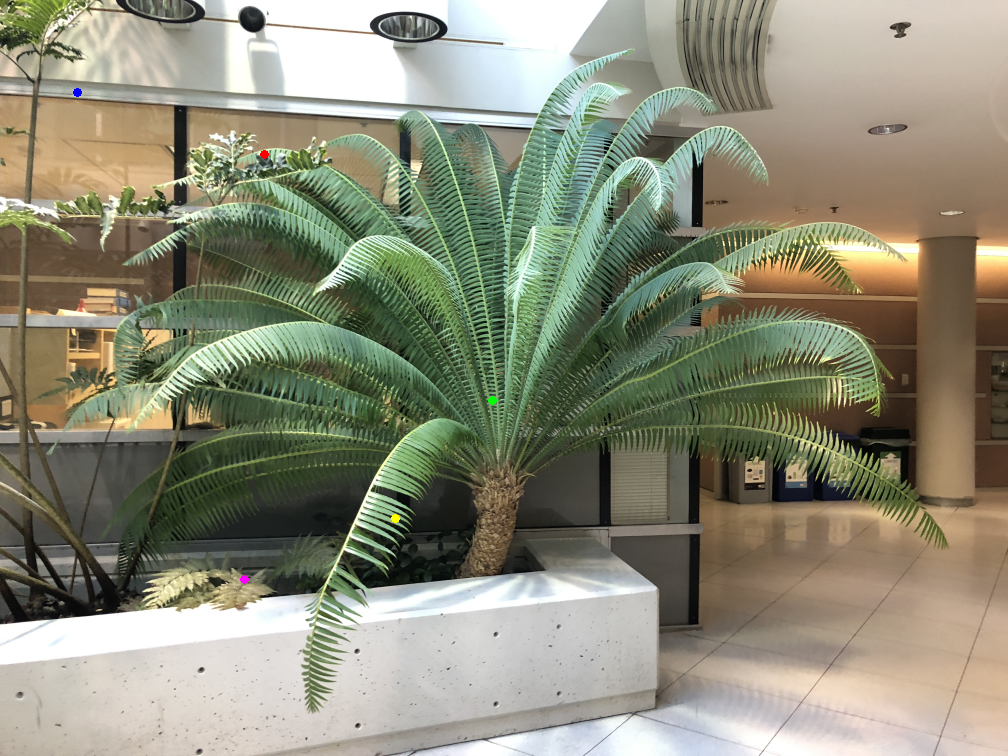

'img2 preds'

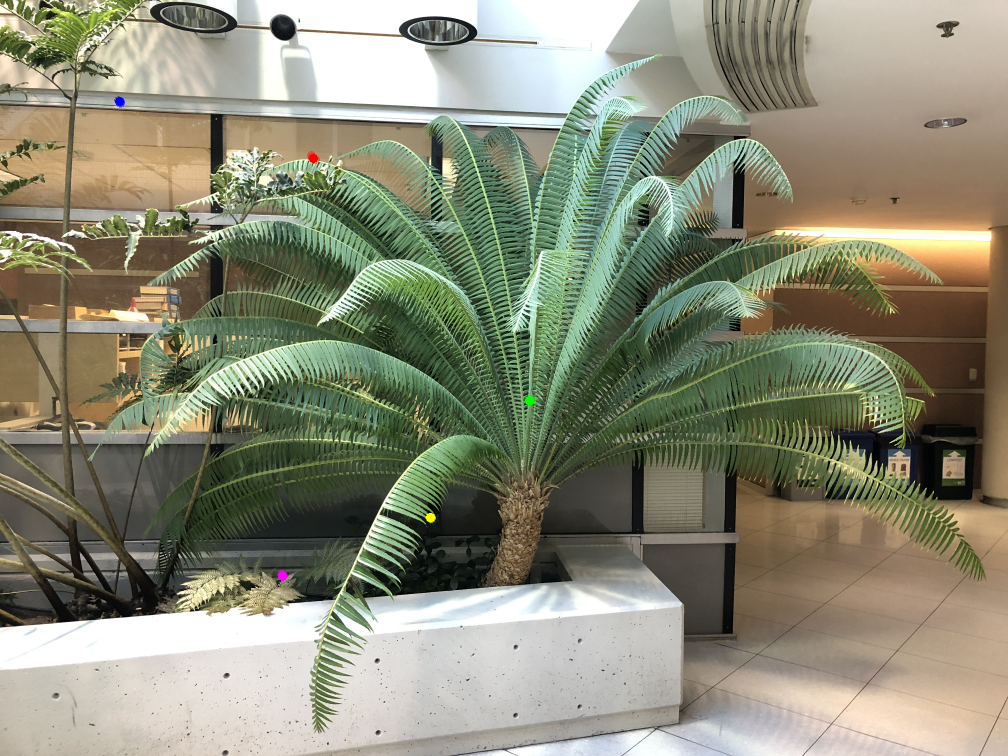

'img2 labels'

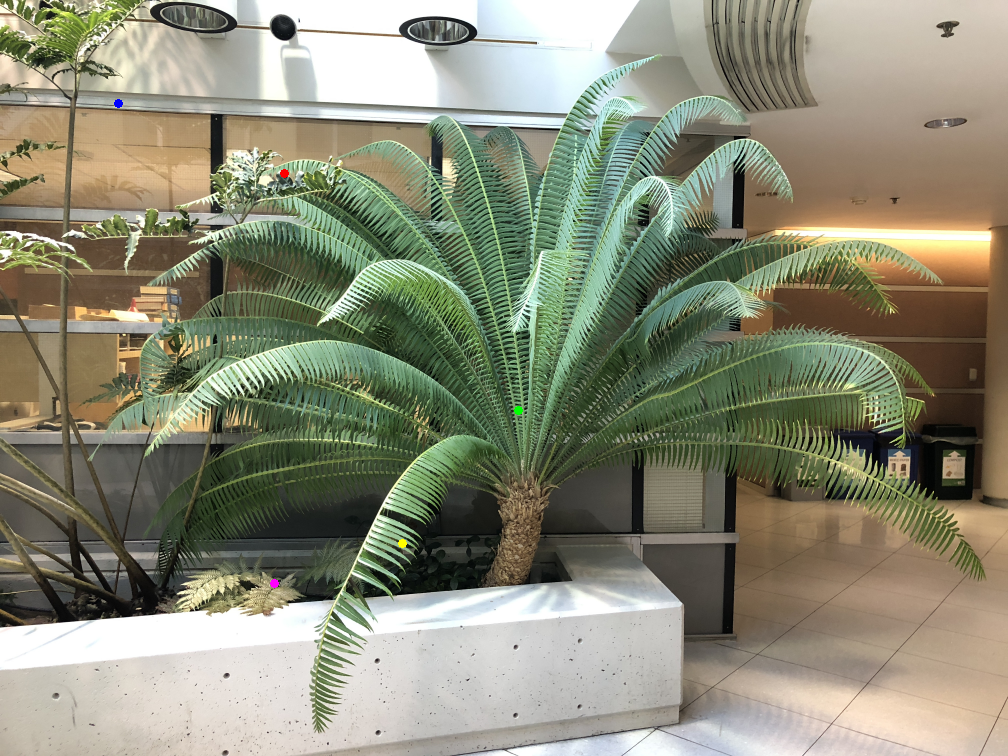

0

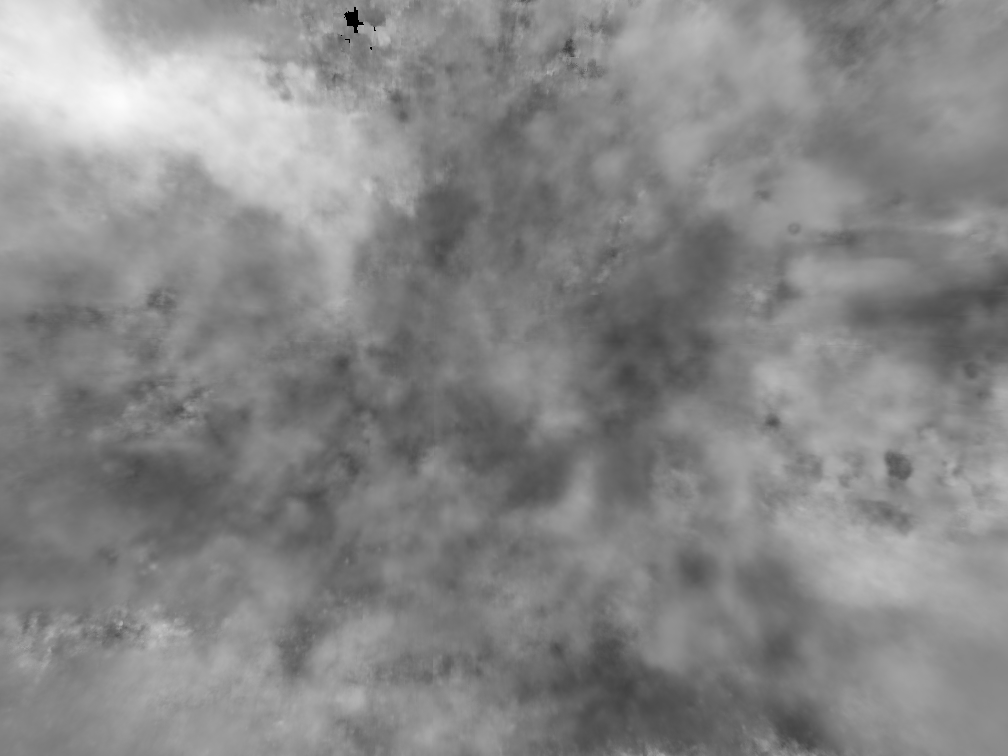

1

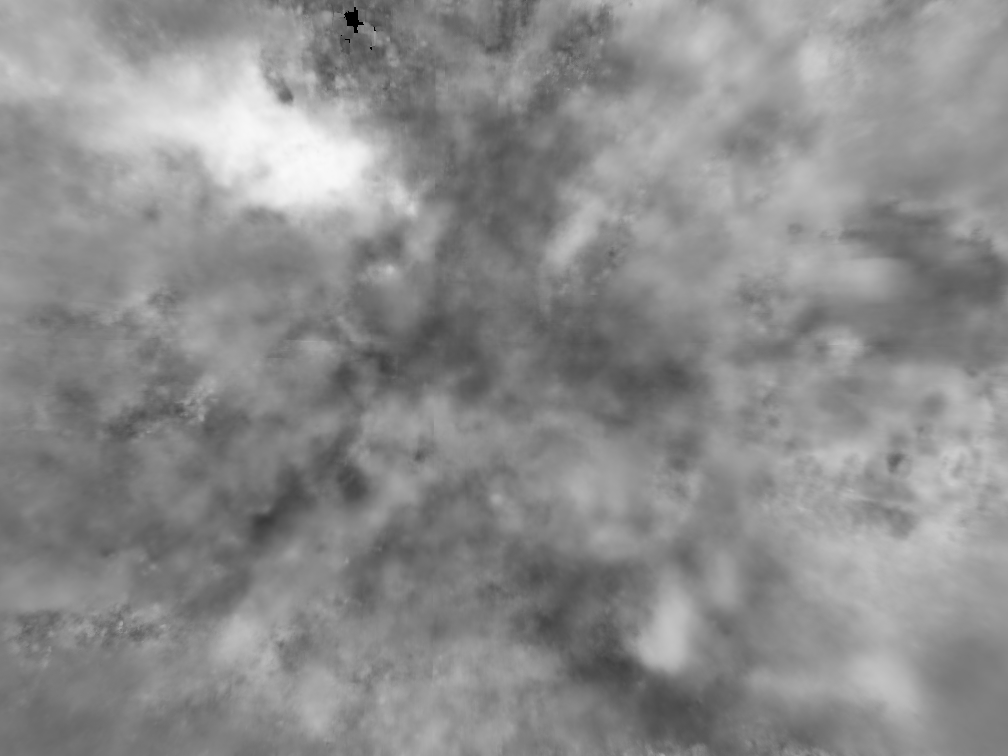

2

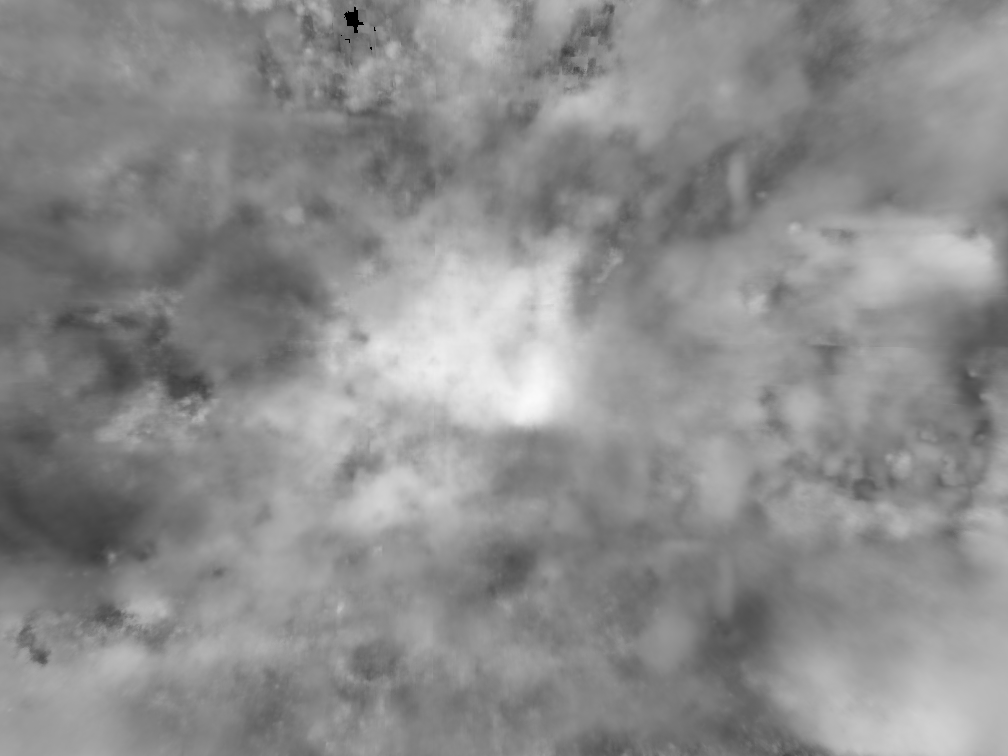

3

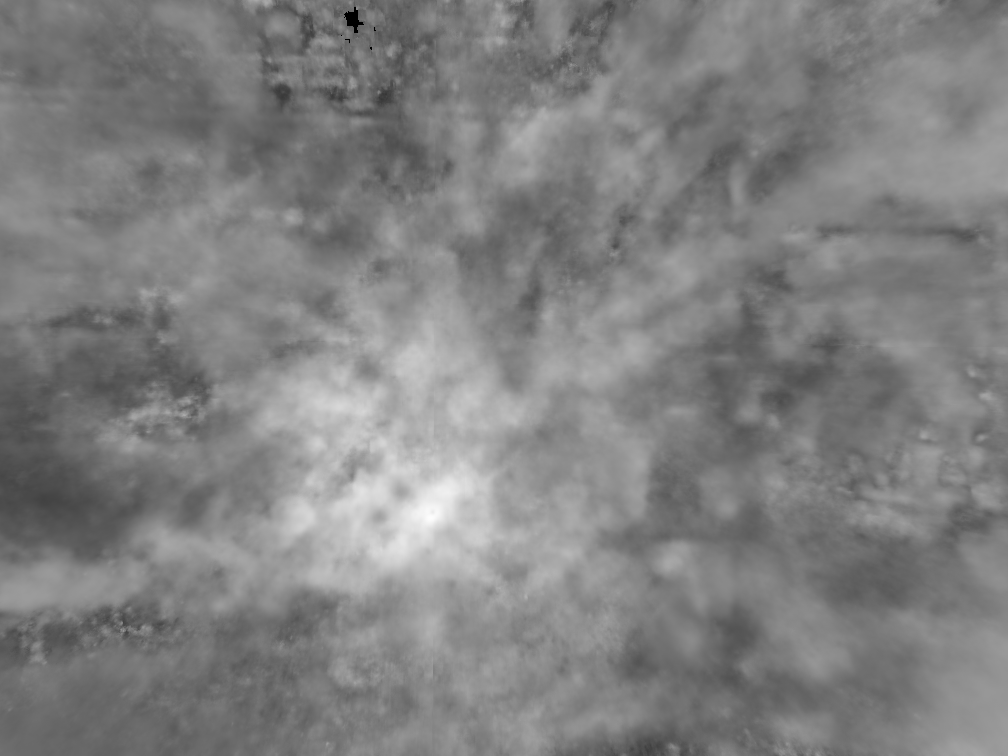

4

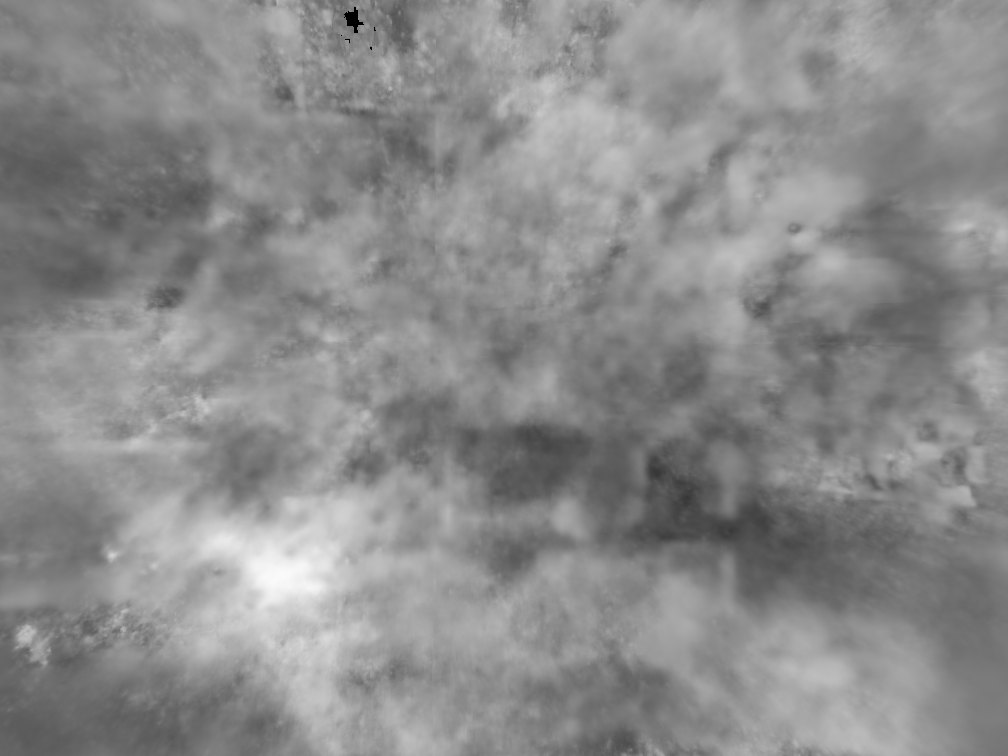

In [19]:
to_pil_image = T.ToPILImage()
colors = [
    np.array([0,0,255]), np.array([255,0,0]), np.array([0,255,0]),
    np.array([255,255,0]), np.array([255,0,255]), np.array([255,255,255])
]

# hwc to chw
img_1 = to_pil_image(img_1_tensor.permute(2, 0, 1))
img_2_for_labels = to_pil_image(img_2_tensor.permute(2, 0, 1))
img_2_for_preds = img_2_for_labels.copy()

orig_draw_r = 4
found_draw_r = 4
k = 5
img_1_drw = ImageDraw.Draw(img_1, 'RGBA')
img_2_gt_drw = ImageDraw.Draw(img_2_for_labels, 'RGBA')
img_2_preds_drw = ImageDraw.Draw(img_2_for_preds, 'RGBA')

heat_maps = []

for i, point in enumerate(points_to_check):
    gt_match = matching_points[i]
    # Draw on source image to see it
    print(point)
    # Draw ellipse given a bounding box of (x0,y0,x1,y1), x in width, y in height, x1>x0 y1>y0
    img_1_drw.ellipse(xy=(point[1] - orig_draw_r, point[0] - orig_draw_r, \
                          point[1] + orig_draw_r, point[0] + orig_draw_r), fill=tuple(colors[i]))

    # Fine nearest Neighbors
    point_features = features_1[point[0], point[1]]
    # distances = ((features_2 - point_features) ** 2).sum(axis=-1)
    distances = cos_sim(features_2, point_features[np.newaxis, np.newaxis,...])
    nearest_idxs = np.dstack(np.unravel_index(np.argsort(-distances, axis=None), distances.shape))[0, :k, ...]

    print(point)
    for n_p in nearest_idxs:
        print(n_p, distances[n_p[0], n_p[1]])

    nearest_p = nearest_idxs[0]
    # Draw ellipse given a bounding box of (x0,y0,x1,y1), x in width, y in height, x1>x0 y1>y0
    img_2_preds_drw.ellipse(xy=(nearest_p[1] - found_draw_r, nearest_p[0] - found_draw_r, \
                          nearest_p[1] + found_draw_r, nearest_p[0] + found_draw_r), fill=tuple(colors[i]))
    # Now draw next matches with lower 
    for near_p in nearest_idxs[1:]:
        img_2_preds_drw.ellipse(xy=(near_p[1] - found_draw_r, near_p[0] - found_draw_r, \
                              near_p[1] + found_draw_r, near_p[0] + found_draw_r),
                          fill=(colors[i][0], colors[i][1], colors[i][2], 100))
        
    # Draw the gt
    img_2_gt_drw.ellipse(xy=(gt_match[1] - found_draw_r, gt_match[0] - found_draw_r, \
                          gt_match[1] + found_draw_r, gt_match[0] + found_draw_r), fill=tuple(colors[i]))
    print('Cosine Similarity to gt match', gt_match, ' :' , cos_sim(point_features, features_2[gt_match[0], gt_match[1]], axis=0))
    
    heat_maps.append((distances + 1)/2)

display('img1', (img_1))
display('img2 preds', (img_2_for_preds))
display('img2 labels', (img_2_for_labels))

for i, h_map in enumerate(heat_maps):
    h_map_as_img = to_pil_image((np.dstack([h_map, h_map, h_map]) * 255).astype(dtype=np.uint8))
    display(i, h_map_as_img)
    



In [20]:
feats_to_check = features_1[points_to_check[:,0], points_to_check[:,1], :]
matching_feats = features_2[matching_points[:,0], matching_points[:,1], :]

print('Cosine Similarity with the gt:')
print(cos_sim(feats_to_check, matching_feats, axis=1))

print('Cosine Similarity with false gt:')
print(cos_sim(np.roll(feats_to_check, 1, axis=0), matching_feats, axis=1))

Cosine Similarity with the gt:
[0.9765329  0.9501093  0.89762336 0.8020745  0.95384437]
Cosine Similarity with false gt:
[ 0.1350709   0.50179136 -0.05078498  0.1966087   0.19528723]


In [21]:
print((np.roll(feats_to_check[:,0:2], 1, axis=0)))
print(feats_to_check[:,0:2])

[[-8.6390175e-04  2.9968697e-01]
 [ 6.6305685e-01 -1.0006217e+00]
 [ 3.8032037e-01  6.3694455e-02]
 [-4.1053945e-01 -3.4098700e-01]
 [-1.3151877e+00 -1.4849538e+00]]
[[ 6.6305685e-01 -1.0006217e+00]
 [ 3.8032037e-01  6.3694455e-02]
 [-4.1053945e-01 -3.4098700e-01]
 [-1.3151877e+00 -1.4849538e+00]
 [-8.6390175e-04  2.9968697e-01]]


In [22]:
# TODO: 
#  1. Search matches for points from the non-matched colmap points. See their heatmaps.
#    This is an intermediate step since they don't need more depth supervision,
#    but they are good keypoints not from the supervision to check.
#  2. Search matches for random points in img_1. See their heatmaps